In [494]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.spatial.distance import pdist
import torch.optim as optim

from matplotlib.lines import Line2D  # Import Line2D for custom legend

from torch.optim.lr_scheduler import ReduceLROnPlateau


We moved all the useful functions from the previous assignments to a separate file utils.py. You can simply import them with the following line. Feel free to add additional functions or modify the existing ones!

In [495]:
from utils import MLP, split_data, Dataset, train

In [496]:
# check if a GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [497]:
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)

n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]

print(
    f"Number of particles: {n_atoms} \nNumber of spatial dimensions: {n_dimensions}",
)

Number of particles: 4 
Number of spatial dimensions: 2


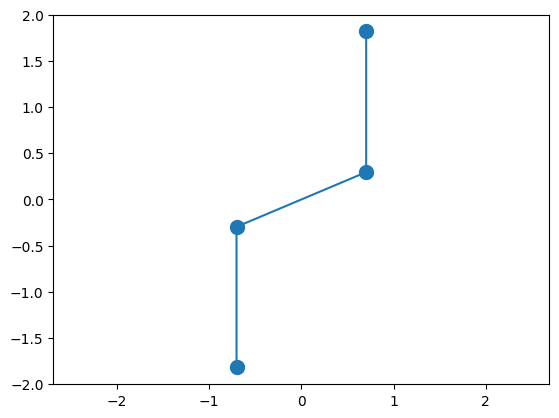

In [498]:
plt.plot(molecule[:, 0], molecule[:, 1], "o-", markersize=10)
plt.axis("equal")

plt.show()

In [499]:
n_samples = 5000
mean = 0
standard_dev = 0.1
noise = np.random.normal(
                 size=(n_samples, n_atoms, n_dimensions),
                 loc=mean, 
                 scale = standard_dev,
)

noised_molecules = noise + molecule
noised_molecules

array([[[ 0.68017535,  1.88845839],
        [ 0.73089429,  0.35355571],
        [-0.81266694, -0.33779555],
        [-0.68335261, -1.79995478]],

       [[ 0.66135449,  1.71565165],
        [ 0.82984633,  0.34823596],
        [-0.59496901, -0.27711028],
        [-0.80087168, -1.88525781]],

       [[ 0.59232922,  1.71260988],
        [ 0.53934018,  0.01733384],
        [-0.84339373, -0.47439754],
        [-0.77829149, -1.92668539]],

       ...,

       [[ 0.73437437,  1.8542449 ],
        [ 0.92932409,  0.32454775],
        [-0.72411546, -0.26229707],
        [-0.76779502, -1.87688147]],

       [[ 0.56557043,  1.78324811],
        [ 0.5547649 ,  0.08801171],
        [-0.85187347, -0.17743347],
        [-0.56620636, -1.78796665]],

       [[ 0.79505619,  1.79583553],
        [ 0.83912861,  0.07508784],
        [-0.64312952, -0.24408261],
        [-0.73099285, -1.85527218]]])

In [500]:
def plot_mollies(mollies, title="Molecules with Noise"):
  labeled = False
  alpha = 50 / n_samples
  for mol in mollies:
    mol = np.array(mol)
    if not labeled:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha, 
              label=f"Probability cloud of molecule with: \n\t{n_samples} samples, \n\tmean: {mean}, \n\tstandard deviation: {standard_dev}")
      labeled = True
    else:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha)

  legend_handle = Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=10, alpha=.5)  # Higher alpha for legend

  plt.axis("equal")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Molecule with Noise")

  plt.legend([legend_handle], [f"Probability cloud of molecule with \n{n_samples} samples, \nmean: {mean}, \nstandard deviation: {standard_dev}"])


  plt.tight_layout()
  plt.show()

# def plot_dataset(my_dataset, title="Molecules with Noise"):
#     # mollies = [my_dataset[i][0].tolist() for i in range(len(my_dataset)) ]
#     # alpha = 50 / n_samples
#     print(mollies)
#     plot_mollies(mollies, title)



In [501]:
noised_molecules

array([[[ 0.68017535,  1.88845839],
        [ 0.73089429,  0.35355571],
        [-0.81266694, -0.33779555],
        [-0.68335261, -1.79995478]],

       [[ 0.66135449,  1.71565165],
        [ 0.82984633,  0.34823596],
        [-0.59496901, -0.27711028],
        [-0.80087168, -1.88525781]],

       [[ 0.59232922,  1.71260988],
        [ 0.53934018,  0.01733384],
        [-0.84339373, -0.47439754],
        [-0.77829149, -1.92668539]],

       ...,

       [[ 0.73437437,  1.8542449 ],
        [ 0.92932409,  0.32454775],
        [-0.72411546, -0.26229707],
        [-0.76779502, -1.87688147]],

       [[ 0.56557043,  1.78324811],
        [ 0.5547649 ,  0.08801171],
        [-0.85187347, -0.17743347],
        [-0.56620636, -1.78796665]],

       [[ 0.79505619,  1.79583553],
        [ 0.83912861,  0.07508784],
        [-0.64312952, -0.24408261],
        [-0.73099285, -1.85527218]]])

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


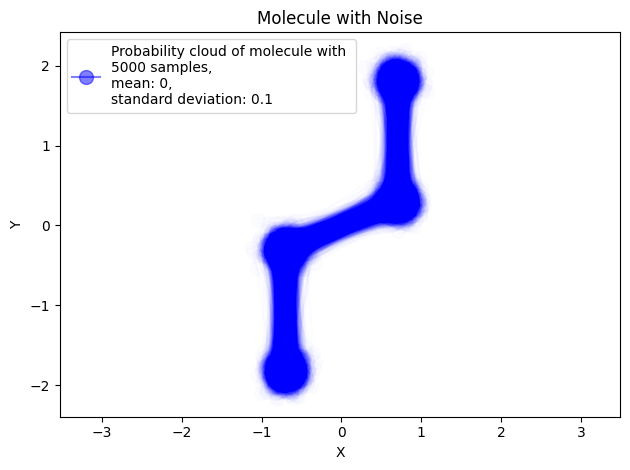

In [502]:
plot_mollies(noised_molecules)

## 1.2 Featurization

Here's an example of how to use pdist:

In [503]:
distances = pdist(molecule)
distances

array([1.524548  , 2.54106427, 3.90343364, 1.52502927, 2.54106427,
       1.524548  ])

We can check that these distances are correct:

In [504]:
# Distance atom 0 - 1
print(f"{np.linalg.norm(molecule[0,:] - molecule[1,:]):.6f}")
# Distance atom 0 - 2
print(f"{np.linalg.norm(molecule[0,:] - molecule[2,:]):.6f}")
# Distance atom 0 - 3
print(f"{np.linalg.norm(molecule[0,:] - molecule[3,:]):.6f}")
# Distance atom 1 - 2
print(f"{np.linalg.norm(molecule[1,:] - molecule[2,:]):.6f}")
# Distance atom 1 - 3
print(f"{np.linalg.norm(molecule[1,:] - molecule[3,:]):.6f}")
# Distance atom 2 - 3
print(f"{np.linalg.norm(molecule[2,:] - molecule[3,:]):.6f}")


1.524548
2.541064
3.903434
1.525029
2.541064
1.524548


In [505]:
flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in noised_molecules]
distances = [pdist(mol) for mol in noised_molecules]
potentials = [(1 / dist) for dist in distances]
# potentials
distances


[array([1.53574042, 2.68044487, 3.93237844, 1.69131542, 2.57637376,
        1.46786642]),
 array([1.3777573 , 2.35572682, 3.88647067, 1.55600664, 2.76545396,
        1.62127554]),
 array([1.69610397, 2.61616166, 3.88883931, 1.46756697, 2.34848121,
        1.45374629]),
 array([1.43018207, 2.83641296, 4.02336777, 1.70682325, 2.72001631,
        1.27896611]),
 array([1.70566623, 2.70437572, 4.04994142, 1.63468833, 2.57086856,
        1.51054097]),
 array([1.39282749, 2.48591199, 3.72402889, 1.53295008, 2.44097841,
        1.47915646]),
 array([1.56815447, 2.42372461, 3.91291671, 1.34023666, 2.54767979,
        1.54242154]),
 array([1.60535914, 2.60858657, 3.91629619, 1.6410082 , 2.46851397,
        1.61555624]),
 array([1.63517897, 2.56779573, 3.91386217, 1.44763505, 2.50106317,
        1.41402346]),
 array([1.57273567, 2.59781385, 4.02158411, 1.37736022, 2.53615643,
        1.55804359]),
 array([1.58293639, 2.69201331, 4.11678467, 1.69539875, 2.72149705,
        1.63277199]),
 array([1.

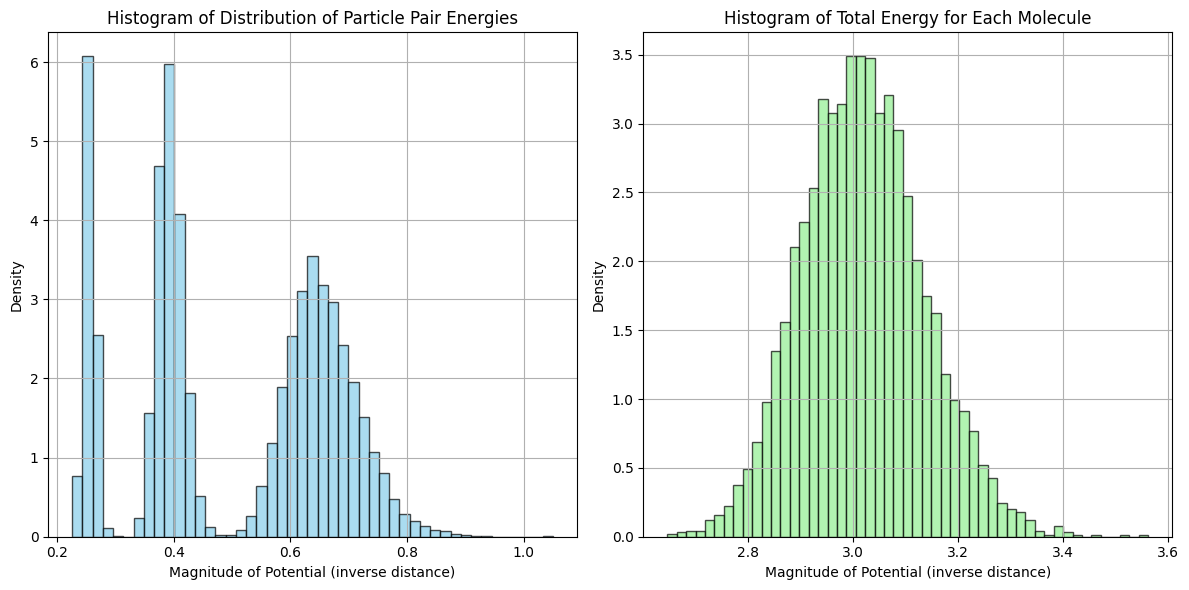

In [506]:
# Create the figure and axes (two subplots side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pairwise_energies = np.concatenate(potentials)

# Plot the first histogram
ax[0].hist(pairwise_energies, bins='auto', density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].set_title("Histogram of Distribution of Particle Pair Energies")
ax[0].set_xlabel("Magnitude of Potential (inverse distance)")
ax[0].set_ylabel("Density")
ax[0].grid(True)

total_energies = [sum(potential) for potential in potentials]


# Plot the second histogram
ax[1].hist(total_energies, bins='auto', density=True, color='lightgreen', edgecolor='black', alpha=0.7)
ax[1].set_title("Histogram of Total Energy for Each Molecule")
ax[1].set_xlabel("Magnitude of Potential (inverse distance)")
ax[1].set_ylabel("Density")
ax[1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()



In [507]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

In [508]:
# define fraction of data used for training
train_fraction = .8
n_train = int(train_fraction * n_samples)

# get indices for training and test set
ids = np.arange(n_samples)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))

flattened_coordinates = np.array(flattened_coordinates)
total_energies = np.array(total_energies)
distances = np.array(distances)

# generate datasets for training and testing        
coords_train_data = Data(flattened_coordinates[ids_train], total_energies[ids_train])
coords_test_data = Data(flattened_coordinates[ids_test], total_energies[ids_test])
dists_train_data = Data(distances[ids_train], total_energies[ids_train])
dists_test_data = Data(distances[ids_test], total_energies[ids_test])

In [509]:
distances[ids_train].shape

(4000, 6)

In [510]:
batch_size = 128
coords_train_loader = DataLoader(coords_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
coord_test_loader = DataLoader(coords_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

dists_train_loader = DataLoader(dists_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
dists_test_loader = DataLoader(dists_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

In [511]:
# import torch
# import torch.nn as nn

# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model
class MLPPotentialEstimator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLPPotentialEstimator, self).__init__()
        
        # Create hidden layers dynamically based on the hidden_sizes list
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ELU(alpha=1.0))  # Activation after each hidden layer
            in_size = hidden_size
        
        # The final output layer (no activation, as we want a scalar output)
        layers.append(nn.Linear(in_size, output_size))
        
        # Use nn.Sequential to combine the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    """
    Function to train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training data.
        criterion: The loss function (e.g., MSELoss).
        optimizer: The optimizer to update weights (e.g., Adam).
        num_epochs: The number of epochs to train.
    """
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  # Set model to training mode

        # Iterate over the batches in the train_loader
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass: get the model's predictions
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_loss += loss.item()
            # For regression, no need to compute accuracy, but we can track the loss
            total += labels.size(0)
        
        # Print statistics after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
    
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No need to compute gradients for evaluation
            test_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            # Average test loss
            avg_test_loss = test_loss / len(test_loader)
            print(f"Test Loss: {avg_test_loss:.4f}")
            test_losses.append(test_loss)

        model.train()  # Set the model back to training mode for the next epoch

    return train_losses, test_losses


def evaluate_regression_model(model, dataloader, criterion, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.to(device)
        model.eval()  # Set the model to evaluation mode

        total_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation for evaluation
            for batch in dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                all_preds.extend(outputs.cpu().detach().numpy().flatten())  # Flatten output
                all_labels.extend(labels.cpu().detach().numpy().flatten())  # Flatten labels


        # print(type(all_preds))
        # all_preds = np.array(all_preds)
        # all_labels = np.array(all_labels)

        # # Ensure correct data types
        # all_preds = all_preds.astype(np.float64)
        # all_labels = all_labels.astype(np.float64)

        # # Check for NaN or infinite values
        # if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_labels)):
        #     print("NaN values found in predictions or labels.")
        # if np.any(np.isinf(all_preds)) or np.any(np.isinf(all_labels)):
        #     print("Infinite values found in predictions or labels.")

        #  # Debugging the shapes and types
        # print(f"Shape of all_preds: {all_preds.shape}")
        # print(f"Shape of all_labels: {all_labels.shape}")
        # print(f"Type of all_preds: {type(all_preds)}")
        # print(f"Type of all_labels: {type(all_labels)}")

        # Compute metrics
        avg_loss = total_loss / len(dataloader)
        mse = mean_squared_error(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)

        return {
            "loss": avg_loss,
            "mse": mse,
            "mae": mae,
            "r2": r2,
        }
    
# def plot_regression_model(model,)
        

In [512]:
mean_squared_error(np.array([1, 2, 3]), np.array([4, 5, 6]))

9.0

In [513]:
# 1. Hyperparameters
coords_input_size = 8  # Example input size (number of features)
dists_input_size = 6
hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
output_size = 1  # Single output (potential energy)

coords_model = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
dists_model = MLPPotentialEstimator(dists_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
coords_optimizer = optim.SGD(coords_model.parameters(), lr=0.001)
dists_optimizer = optim.SGD(dists_model.parameters(), lr=.001)
scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)






/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [514]:
num_epochs = 500
coords_train_losses, coords_test_losses = train_model(coords_model, coords_train_loader, coord_test_loader, criterion, coords_optimizer, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/500], Loss: 7.5466
Test Loss: 6.7293
Epoch [2/500], Loss: 5.9511
Test Loss: 5.2419
Epoch [3/500], Loss: 4.5421
Test Loss: 3.8943
Epoch [4/500], Loss: 3.2548
Test Loss: 2.6573
Epoch [5/500], Loss: 2.0906
Test Loss: 1.5798
Epoch [6/500], Loss: 1.1393
Test Loss: 0.7689
Epoch [7/500], Loss: 0.5003
Test Loss: 0.2967
Epoch [8/500], Loss: 0.1757
Test Loss: 0.0963
Epoch [9/500], Loss: 0.0566
Test Loss: 0.0338
Epoch [10/500], Loss: 0.0235
Test Loss: 0.0177
Epoch [11/500], Loss: 0.0157
Test Loss: 0.0140
Epoch [12/500], Loss: 0.0142
Test Loss: 0.0131
Epoch [13/500], Loss: 0.0139
Test Loss: 0.0129
Epoch [14/500], Loss: 0.0138
Test Loss: 0.0127
Epoch [15/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [16/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [17/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [18/500], Loss: 0.0139
Test Loss: 0.0127
Epoch [19/500], Loss: 0.0138
Test Loss: 0.0127
Epoch [20/500], Loss: 0.0137
Test Loss: 0.0128
Epoch [21/500], Loss: 0.0138
Test Loss: 0.0126
Epoch [22/500], Loss: 

In [515]:
dists_num_epochs = 500
dists_train_losses, dists_test_losses = train_model(dists_model, dists_train_loader, dists_test_loader, dists_criterion, dists_optimizer, dists_num_epochs)


Epoch [1/500], Loss: 7.5990
Test Loss: 6.3580
Epoch [2/500], Loss: 5.1127
Test Loss: 3.8466
Epoch [3/500], Loss: 2.5739
Test Loss: 1.3581
Epoch [4/500], Loss: 0.6112
Test Loss: 0.1521
Epoch [5/500], Loss: 0.0551
Test Loss: 0.0184
Epoch [6/500], Loss: 0.0153
Test Loss: 0.0134
Epoch [7/500], Loss: 0.0144
Test Loss: 0.0133
Epoch [8/500], Loss: 0.0143
Test Loss: 0.0132
Epoch [9/500], Loss: 0.0141
Test Loss: 0.0132
Epoch [10/500], Loss: 0.0142
Test Loss: 0.0131
Epoch [11/500], Loss: 0.0143
Test Loss: 0.0132
Epoch [12/500], Loss: 0.0143
Test Loss: 0.0132
Epoch [13/500], Loss: 0.0143
Test Loss: 0.0131
Epoch [14/500], Loss: 0.0142
Test Loss: 0.0132
Epoch [15/500], Loss: 0.0142
Test Loss: 0.0132
Epoch [16/500], Loss: 0.0141
Test Loss: 0.0131
Epoch [17/500], Loss: 0.0142
Test Loss: 0.0132
Epoch [18/500], Loss: 0.0142
Test Loss: 0.0132
Epoch [19/500], Loss: 0.0141
Test Loss: 0.0131
Epoch [20/500], Loss: 0.0143
Test Loss: 0.0132
Epoch [21/500], Loss: 0.0141
Test Loss: 0.0131
Epoch [22/500], Loss: 

In [516]:
# distances

In [517]:
# dists_test_losses

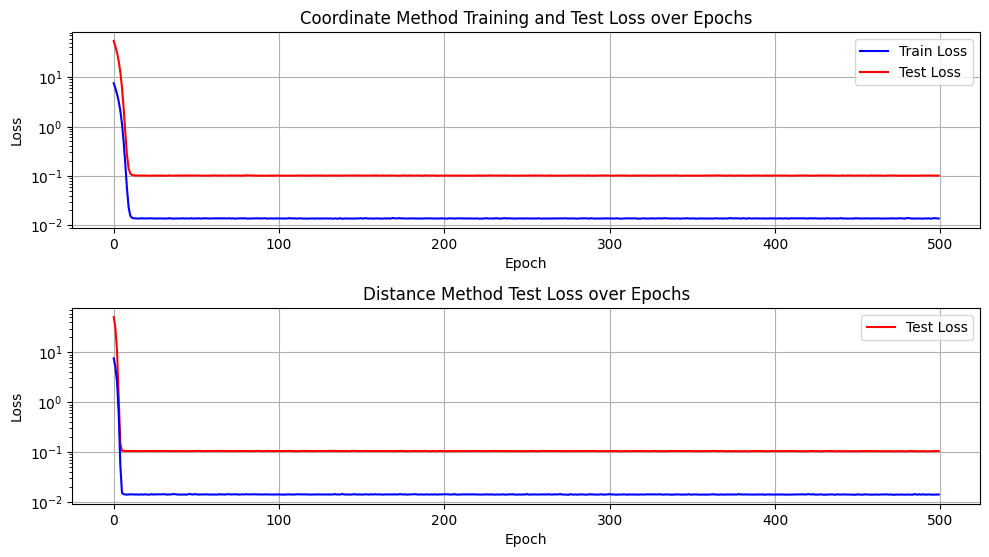

In [518]:
plt.figure(figsize=(10, 8))

# First subplot (top)
plt.subplot(3, 1, 1)  
plt.plot(range(len(coords_train_losses)), coords_train_losses, label="Train Loss", color="blue")
plt.plot(range(len(coords_test_losses)), coords_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coordinate Method Training and Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_test_losses)), dists_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Distance Method Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

# plt.subplot(3, 1, 3)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_train_losses)), dists_train_losses, label="Train Loss", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Distance Method Training Loss over Epochs")
# plt.legend()
# plt.yscale('log')
# plt.grid(True)


plt.tight_layout()

plt.show()

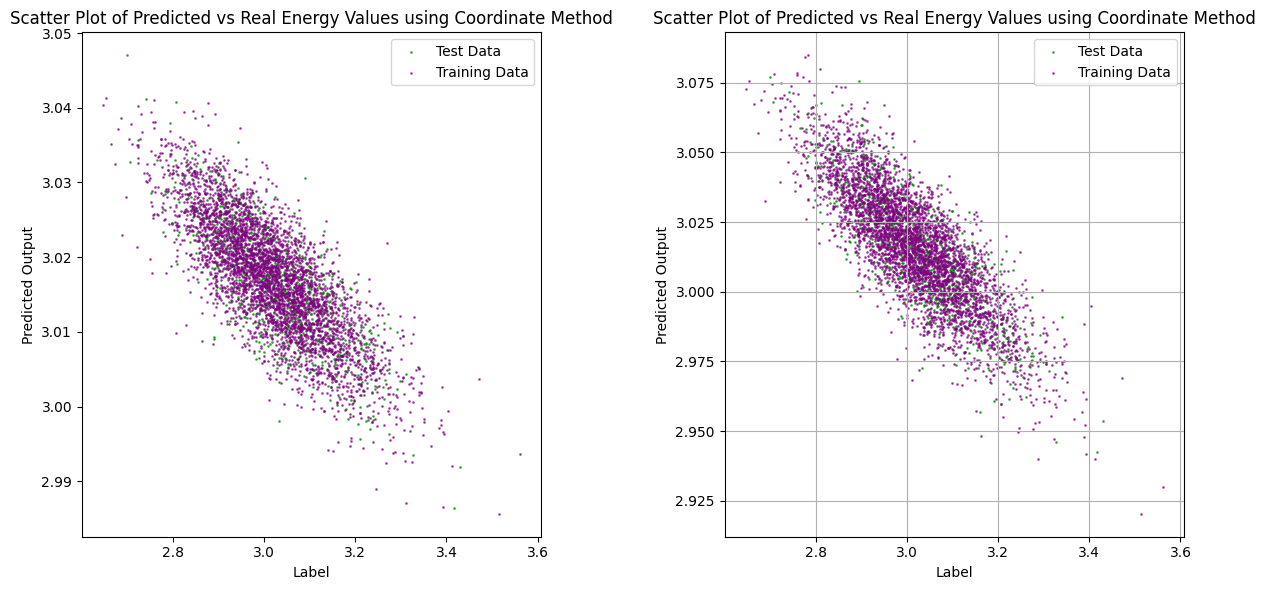

In [519]:
with torch.no_grad():
  coords_test_pred = []
  coords_test_real = []
  coords_train_pred = []
  coords_train_real = []

  dists_test_pred = []
  dists_test_real = []
  dists_train_pred = []
  dists_train_real = []

  for inputs, label in coords_test_data:
    output = coords_model(inputs)
    coords_test_pred.append(output) 
    coords_test_real.append(label)

  for inputs, label in coords_train_data:
    output = coords_model(inputs)
    coords_train_pred.append(output) 
    coords_train_real.append(label)
  
  for inputs, label in dists_test_data:
    output = dists_model(inputs)
    dists_test_pred.append(output) 
    dists_test_real.append(label)

  for inputs, label in dists_train_data:
    output = dists_model(inputs)
    dists_train_pred.append(output) 
    dists_train_real.append(label)
    
  # print(len(coords_input))
  # print(len(coords_test_pred))

  # len(coords_test_data)
  # coords_test_data[0]

  # test_coords = coords_test_data[:,0]
  # test_labels = coords_test_data[:,1]
  # train_coords = coords_train_data[:,0]
  # train_labels = coords_train_data[:,1] 

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns
  ax1, ax2 = axes
  # plt.figure(figsize=(10, 6))

  # Scatter plot for predicted values
  ax1.scatter(coords_test_real, coords_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax1.scatter(coords_train_real, coords_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax1.set_xlabel('Label')
  ax1.set_ylabel('Predicted Output')
  ax1.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')

  ax2.scatter(dists_test_real, dists_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax2.scatter(dists_train_real, dists_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax2.set_xlabel('Label')
  ax2.set_ylabel('Predicted Output')
  ax2.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')


  ax1.legend()
  ax2.legend()

  plt.tight_layout()

  # Show grid for better readability
  plt.grid(True)
  fig.subplots_adjust(wspace=0.4, hspace=0.6)

  # Display the plot
  plt.show()

In [520]:
evaluate_regression_model(coords_model, coord_test_loader, criterion)



{'loss': 0.012690907111391425,
 'mse': 0.014020049,
 'mae': 0.09461973,
 'r2': -0.11947485941666858}

In [521]:
for inputs, label in dists_test_data:
  output = dists_model(inputs)
  print(output)
  dists_test_pred.append(output) 
  dists_test_real.append(label)

# for inputs, label in dists_train_data:
#   output = dists_model(inputs)
#   dists_train_pred.append(output) 
#   dists_train_real.append(label)

tensor([3.0188], grad_fn=<ViewBackward0>)
tensor([3.0182], grad_fn=<ViewBackward0>)
tensor([3.0191], grad_fn=<ViewBackward0>)
tensor([2.9902], grad_fn=<ViewBackward0>)
tensor([3.0199], grad_fn=<ViewBackward0>)
tensor([3.0216], grad_fn=<ViewBackward0>)
tensor([3.0086], grad_fn=<ViewBackward0>)
tensor([3.0192], grad_fn=<ViewBackward0>)
tensor([3.0202], grad_fn=<ViewBackward0>)
tensor([3.0255], grad_fn=<ViewBackward0>)
tensor([3.0096], grad_fn=<ViewBackward0>)
tensor([3.0205], grad_fn=<ViewBackward0>)
tensor([3.0148], grad_fn=<ViewBackward0>)
tensor([3.0315], grad_fn=<ViewBackward0>)
tensor([3.0530], grad_fn=<ViewBackward0>)
tensor([3.0182], grad_fn=<ViewBackward0>)
tensor([3.0303], grad_fn=<ViewBackward0>)
tensor([3.0089], grad_fn=<ViewBackward0>)
tensor([3.0376], grad_fn=<ViewBackward0>)
tensor([3.0025], grad_fn=<ViewBackward0>)
tensor([2.9898], grad_fn=<ViewBackward0>)
tensor([3.0280], grad_fn=<ViewBackward0>)
tensor([3.0585], grad_fn=<ViewBackward0>)
tensor([3.0140], grad_fn=<ViewBack

## 2 Data augmenatation

You can use this function to rotate the samples in your dataset.

In [522]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

This is how you can permute data:

In [523]:
ids = [1,2,3,0]
molecule_permuted = molecule[ids,:]

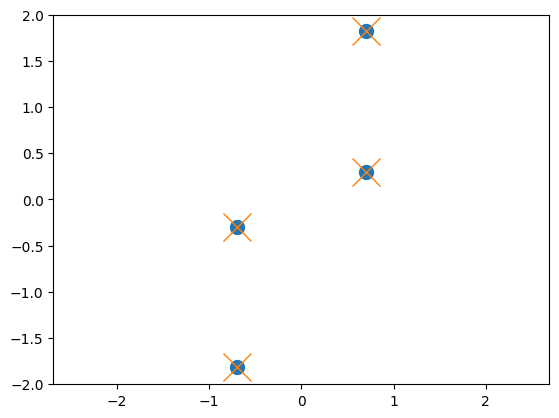

In [524]:
plt.plot(molecule[:, 0], molecule[:, 1], "o", markersize=10)
plt.axis("equal")
plt.plot(molecule_permuted[:, 0], molecule_permuted[:, 1], "x", markersize=20)
plt.axis("equal")

plt.show()

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


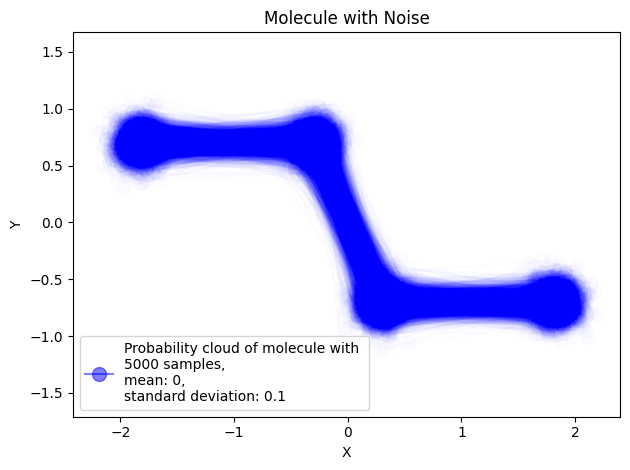

In [525]:
rotated_noised_molecules = [np.transpose(rotate(np.transpose(molly), np.pi / 2)) for molly in noised_molecules]
plot_mollies(rotated_noised_molecules, "Rotated Molecule with Noise")

# noised_molecules[0]

In [526]:
def permute_without_fixed_points(coords):
    n = len(coords)
    while True:
        perm = torch.randperm(n)  # Generate random permutation of indices
        if not torch.all(perm == torch.arange(n)):  # Check for no fixed points
            return coords[perm]  # Apply permutation to the tensor

In [ ]:
rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in rotated_noised_molecules]
rotated_distances = [pdist(mol) for mol in noised_molecules]
rotated_potentials = [(1 / dist) for dist in rotated_distances]
rotated_total_energies = [sum(potential) for potential in rotated_potentials]

permutated_rotated_noised_molecules = [permute_without_fixed_points(molly) for molly in rotated_noised_molecules]
permutated_rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in permutated_rotated_noised_molecules]
permutated_rotated_distances = [permute_without_fixed_points(molly) for molly in rotated_distances]

rotated_coords_data = Data(flattened_coordinates, total_energies)
rotated_dists_data = Data(distances, total_energies)
permutated_rotated_coords_data = Data(np.array(permutated_rotated_flattened_coordinates), total_energies)
permutated_rotated_dists_data = Data(np.array(permutated_rotated_distances), total_energies)

batch_size = 128
rotated_coords_loader = DataLoader(rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

rotated_dists_loader = DataLoader(rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_coords_loader = DataLoader(permutated_rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_dists_loader = DataLoader(permutated_rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

print("Rotated coords model: ", evaluate_regression_model(coords_model, rotated_coords_loader, criterion))
print("Rotated distances model: ", evaluate_regression_model(dists_model, rotated_dists_loader, criterion))

print("Permutated rotated coords model: ", evaluate_regression_model(coords_model, permutated_rotated_coords_loader, criterion))
print("Permutated rotated distances model: ", evaluate_regression_model(dists_model, permutated_rotated_dists_loader, criterion))


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

Rotated coords model:  {'loss': 0.013436150900088251, 'mse': 0.014970473, 'mae': 0.09727034, 'r2': -0.11246078597384046}
Rotated distances model:  {'loss': 0.013932472444139421, 'mse': 0.01798084, 'mae': 0.1065229, 'r2': -0.33616214240910014}
Permutated rotated coords model:  {'loss': 0.12783678006380797, 'mse': 0.12824163, 'mae': 0.33048046, 'r2': -8.529677873748229}
Permutated rotated distances model:  {'loss': 0.040204463293775916, 'mse': 0.04511247, 'mae': 0.17106307, 'r2': -2.352322558043376}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

In [528]:
permutated_rotated_noised_molecules

[array([[ 0.33779555, -0.81266694],
        [ 1.79995478, -0.68335261],
        [-1.88845839,  0.68017535],
        [-0.35355571,  0.73089429]]),
 array([[-1.71565165,  0.66135449],
        [ 1.88525781, -0.80087168],
        [ 0.27711028, -0.59496901],
        [-0.34823596,  0.82984633]]),
 array([[-0.01733384,  0.53934018],
        [ 1.92668539, -0.77829149],
        [-1.71260988,  0.59232922],
        [ 0.47439754, -0.84339373]]),
 array([[ 1.76181966, -0.78109058],
        [-0.51379867,  0.70889261],
        [ 0.48739145, -0.67344742],
        [-1.94161045,  0.7911987 ]]),
 array([[-1.94957753,  0.90341787],
        [ 1.74735037, -0.75028995],
        [-0.24413908,  0.87554365],
        [ 0.23816219, -0.68637549]]),
 array([[ 0.2507782 , -0.75556721],
        [-1.7676043 ,  0.69560145],
        [-0.37575154,  0.64350264],
        [ 1.72218132, -0.60431678]]),
 array([[-0.32581002,  0.6039425 ],
        [ 0.23885498, -0.61153589],
        [-1.89274218,  0.54203878],
        [ 1.7616

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


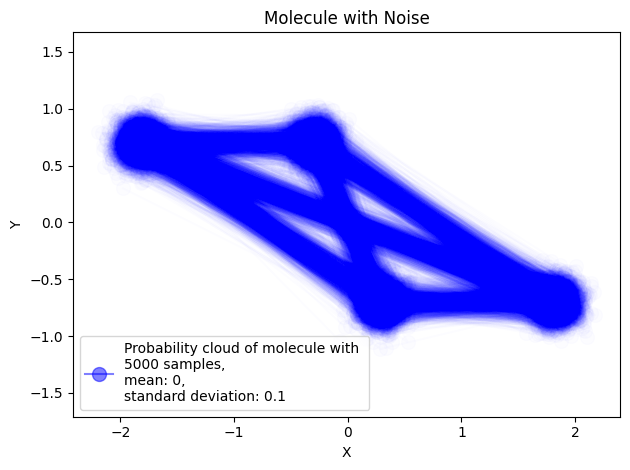

In [529]:

plot_mollies(permutated_rotated_noised_molecules, "Permutated and Rotated Molecules with Noise")
# permutated_rotated_noised_molecules

In [ ]:
# 2.3

augmented_coords1 = np.vstack((rotated_flattened_coordinates, flattened_coordinates))
permutated_coords_without_rotating = [np.reshape(permute_without_fixed_points(molly), (n_atoms*n_dimensions)) for molly in noised_molecules]
augmented_coords2 = np.vstack((flattened_coordinates, permutated_coords_without_rotating))

print(augmented_coords1)
print(augmented_coords2)

def get_dists_from_flattened(mol):
  x1, y1, x2, y2, x3, y3, x4, y4 = mol
  d12 = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** .5
  d13 = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** .5
  d14 = ((x1 - x4) ** 2 + (y1 - y4) ** 2) ** .5
  d23 = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** .5
  d24 = ((x2 - x4) ** 2 + (y2 - y4) ** 2) ** .5
  d34 = ((x3 - x4) ** 2 + (y3 - y4) ** 2) ** .5
  rtn = [d12, d13, d14, d23, d24, d34]
  return rtn


augmented_distances1 = [get_dists_from_flattened(mol) for mol in augmented_coords1]
augmented_potentials1 = [(1 / dist) for dist in augmented_coords1]
augmented_total_energies1 = [sum(potential) for potential in augmented_potentials1]

augmented_distances2 = [get_dists_from_flattened(mol) for mol in augmented_coords2]
augmented_potentials2 = [(1 / dist) for dist in augmented_coords2]
augmented_total_energies2 = [sum(potential) for potential in augmented_potentials2]

train_fraction = .8
n_train = int(train_fraction * n_samples * 2)

# get indices for training and test set
ids = np.arange(n_samples * 2)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))

# generate datasets for training and testing        
aug1_train_data = Data(augmented_coords1[ids_train], augmented_total_energies1[ids_train])
aug1_test_data = Data(augmented_coords1[ids_test], augmented_total_energies1[ids_test])
aug2_train_data = Data(augmented_distances2[ids_train], augmented_total_energies2[ids_train])
aug2_test_data = Data(augmented_distances2[ids_test], augmented_total_energies2[ids_test])


# coords_input_size = 8  # Example input size (number of features)
# dists_input_size = 6
# hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
# output_size = 1  # Single output (potential energy)

augmented_model1 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
augmented_model2 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
augmented_optimizer1 = optim.SGD(augmented_model1.parameters(), lr=0.001)
augmented_optimizer2 = optim.SGD(augmented_model2.parameters(), lr=.001)
# scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)

# original_and_rotated_coords


[[-1.88845839  0.68017535 -0.35355571 ... -0.81266694  1.79995478
  -0.68335261]
 [-1.71565165  0.66135449 -0.34823596 ... -0.59496901  1.88525781
  -0.80087168]
 [-1.71260988  0.59232922 -0.01733384 ... -0.84339373  1.92668539
  -0.77829149]
 ...
 [ 0.73437437  1.8542449   0.92932409 ... -0.26229707 -0.76779502
  -1.87688147]
 [ 0.56557043  1.78324811  0.5547649  ... -0.17743347 -0.56620636
  -1.78796665]
 [ 0.79505619  1.79583553  0.83912861 ... -0.24408261 -0.73099285
  -1.85527218]]
[[ 0.68017535  1.88845839  0.73089429 ... -0.33779555 -0.68335261
  -1.79995478]
 [ 0.66135449  1.71565165  0.82984633 ... -0.27711028 -0.80087168
  -1.88525781]
 [ 0.59232922  1.71260988  0.53934018 ... -0.47439754 -0.77829149
  -1.92668539]
 ...
 [-0.72411546 -0.26229707 -0.76779502 ...  1.8542449   0.92932409
   0.32454775]
 [-0.85187347 -0.17743347 -0.56620636 ...  1.78324811  0.5547649
   0.08801171]
 [ 0.79505619  1.79583553 -0.73099285 ... -0.24408261  0.83912861
   0.07508784]]


IndexError: index 5671 is out of bounds for axis 0 with size 5000

In [534]:
num_epochs = 500
augmented_coords_train_losses, coords_test_losses = train_model(coords_model, coords_train_loader, coord_test_loader, criterion, coords_optimizer, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/500], Loss: 8.5832
Test Loss: 7.6396
Epoch [2/500], Loss: 6.7504
Test Loss: 5.9381
Epoch [3/500], Loss: 5.1404
Test Loss: 4.4025
Epoch [4/500], Loss: 3.6853
Test Loss: 3.0174
Epoch [5/500], Loss: 2.4000
Test Loss: 1.8373
Epoch [6/500], Loss: 1.3593
Test Loss: 0.9487
Epoch [7/500], Loss: 0.6434
Test Loss: 0.4023
Epoch [8/500], Loss: 0.2504
Test Loss: 0.1457
Epoch [9/500], Loss: 0.0869
Test Loss: 0.0512
Epoch [10/500], Loss: 0.0330
Test Loss: 0.0231
Epoch [11/500], Loss: 0.0183
Test Loss: 0.0157
Epoch [12/500], Loss: 0.0149
Test Loss: 0.0134
Epoch [13/500], Loss: 0.0140
Test Loss: 0.0129
Epoch [14/500], Loss: 0.0137
Test Loss: 0.0128
Epoch [15/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [16/500], Loss: 0.0138
Test Loss: 0.0127
Epoch [17/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [18/500], Loss: 0.0137
Test Loss: 0.0127
Epoch [19/500], Loss: 0.0136
Test Loss: 0.0126
Epoch [20/500], Loss: 0.0136
Test Loss: 0.0127
Epoch [21/500], Loss: 0.0138
Test Loss: 0.0127
Epoch [22/500], Loss: 

KeyboardInterrupt: 